In [1]:
import numpy as np
import pyscf
from pyscf import qmmm,scf,dft,gto
import matplotlib.pyplot as plt
import basis_set_exchange as bse
angstrom = 1 / 0.52917721067
import ipyvolume as ipv

In [3]:
COd=gto.Mole(atom='C 0 0 0 ; O 3.1 0 0 ',unit='bohrs',basis='def2-QZVPP')
COs=gto.Mole(atom='C 0 0 0 ; O 3.1 0 0 ',unit='bohrs',basis='sto-3G')
scf.UHF(COd).run()
scf.UHF(COs).run()

Initialize <pyscf.gto.mole.Mole object at 0x7f09356fcd68> in <pyscf.scf.uhf.UHF object at 0x7f09356fc940>


converged SCF energy = -112.511517840359  <S^2> = 2.5335289e-11  2S+1 = 1


Initialize <pyscf.gto.mole.Mole object at 0x7f09356fcd30> in <pyscf.scf.uhf.UHF object at 0x7f09747230b8>


converged SCF energy = -110.947506927565  <S^2> = 2.1992186e-11  2S+1 = 1


In [4]:
def dm_ccsd(mol,ao):
    calc=scf.UHF(mol)
    includeonly = [0, 1]
    deltaZ=np.array((0.05,-0.05),dtype=float)*ao
    mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords(), deltaZ)
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = mol.atom_charges().astype(np.float)
            q[includeonly] += deltaZ
            return mol.energy_nuc(q)
    mf = NoSelfQMMM()
    hfe=mf.kernel()
    mycc = pyscf.cc.CCSD(mf).set(frozen = 2,max_cycle=100).run()
    dm1 = mycc.make_rdm1()
    dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff[0],dm1[0], mf.mo_coeff[0].conj())
    dm1_ao += np.einsum('pi,ij,qj->pq', mf.mo_coeff[1],dm1[1], mf.mo_coeff[1].conj())
    return dm1_ao

In [5]:
#sto_deriv=(dm_ccsd(COs,1)-dm_ccsd(COs,-1))/2

In [6]:
#def2_deriv=(dm_ccsd(COd,1)-dm_ccsd(COd,-1))/2

In [4]:
#%store sto_deriv
#%store def2_deriv
%store -r sto_deriv
%store -r def2_deriv
def2_deriv

array([[ 5.18629307e-01, -7.89484074e-02,  1.40499483e-01, ...,
        -5.85435269e-05,  4.51964579e-17,  7.74458065e-05],
       [-7.89484074e-02, -3.06252298e-04, -5.45372675e-02, ...,
        -2.14582657e-06,  1.84944130e-18,  2.83866173e-06],
       [ 1.40499483e-01, -5.45372675e-02, -4.94015449e-02, ...,
        -5.09397620e-05,  3.77666297e-17,  6.73869710e-05],
       ...,
       [-5.85435269e-05, -2.14582657e-06, -5.09397620e-05, ...,
        -2.59948211e-05,  1.60939993e-17, -2.42599037e-06],
       [ 4.51964579e-17,  1.84944130e-18,  3.77666297e-17, ...,
         1.60939993e-17, -2.45658438e-05,  1.73686137e-17],
       [ 7.74458065e-05,  2.83866173e-06,  6.73869710e-05, ...,
        -2.42599037e-06,  1.73686137e-17, -2.14431117e-05]])

In [5]:
xv=np.linspace(-2,5.,232)
yv=np.linspace(-3,3,232)
zv=np.array(0.,dtype=float)
xm,ym,zm=np.meshgrid(xv,yv,zv)

In [6]:
gridcoords=np.vstack((xm.flatten(),ym.flatten(),zm.flatten())).T

In [7]:
mol=COs
ao_value = pyscf.dft.numint.eval_ao(mol, gridcoords, deriv=0)
Drho_sto = dft.numint.eval_rho(mol, ao_value, sto_deriv, xctype='LDA')
mol=COd
ao_value = pyscf.dft.numint.eval_ao(mol, gridcoords, deriv=0)
Drho_def = dft.numint.eval_rho(mol, ao_value, def2_deriv, xctype='LDA')

In [8]:
ipv.quickscatter(gridcoords.T[0],gridcoords.T[1],Drho_sto)
ipv.show()

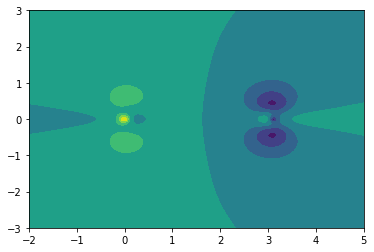

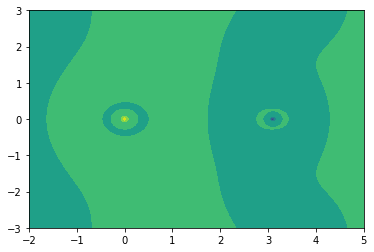

In [9]:
rho_2dsto=np.array([Drho_sto[x::232] for x in range(232)]).T
plt.contourf(xv,yv,rho_2dsto)
plt.show()
rho_2ddef=np.array([Drho_def[x::232] for x in range(232)]).T
plt.contourf(xv,yv,rho_2ddef)
plt.show()

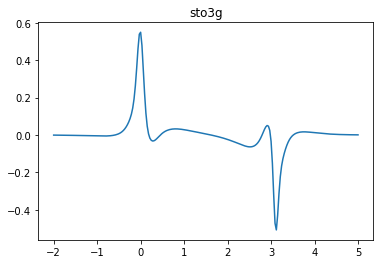

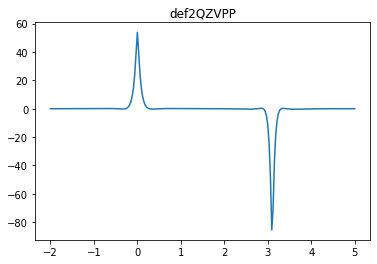

In [10]:
plt.plot(xv,Drho_sto[232*116:232*116+232])
plt.title("sto3g")
plt.show()
plt.plot(xv,Drho_def[232*116:232*116+232])
plt.title("def2QZVPP")
plt.show()

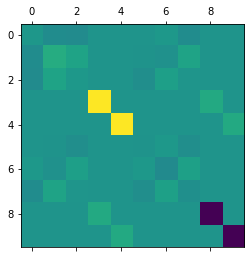

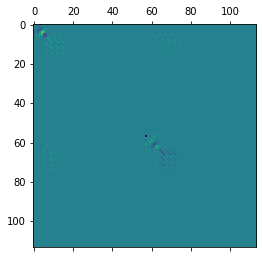

In [11]:
plt.matshow(sto_deriv)
plt.show()
plt.matshow(def2_deriv)

## Figures

[-5.07731168e-01 -4.17127998e-02 -5.79139758e-03 -1.05315534e-03
 -5.59261523e-05  1.46062581e-03  4.23816753e-03  1.35427107e-02
  4.33344479e-02  5.49248336e-01]
[-8.54954452e+01 -2.83310786e-02 -2.63682372e-03 -6.39995247e-04
 -7.56954417e-05  6.55406992e-04  2.52369438e-03  8.56813378e-03
  4.46692424e-02  5.39300393e+01]


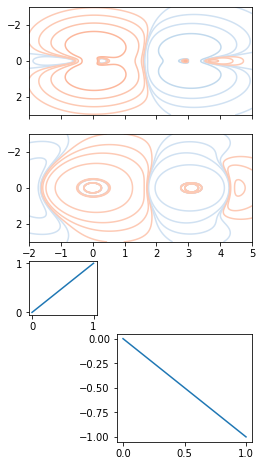

In [12]:
import matplotlib.gridspec as gridspec
from matplotlib import cm
f = plt.figure(figsize=(4, 8))
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 2], height_ratios=[2, 2, 1, 2])
contourSTO = plt.subplot(gs[0, :],xticklabels=[])
contourDEF = plt.subplot(gs[1, :])
dmSTO = plt.subplot(gs[2, 0])
dmDEF = plt.subplot(gs[3, 1])

# contour lines
levels = np.percentile(rho_2dsto.flatten(), np.linspace(0, 100, 10))
print (levels)
colors = []
for level in levels:
    if level < 0:
        cmap = cm.get_cmap('Blues')
        extreme = levels[0]
    else:
        cmap = cm.get_cmap('Reds')
        extreme = levels[-1]
    scaled = level / extreme
    scaled = scaled * .8 + 0.2
    colors.append(cmap(scaled))
contourSTO.contour(xv,yv,rho_2dsto, levels = levels, colors = colors)
contourSTO.set_ylim(3, -3)
#contourSTO.get_xaxis().remove()
#print (dir(contourSTO))
levels = np.percentile(rho_2ddef.flatten(), np.linspace(0, 100, 10))
print (levels)
colors = []
for level in levels:
    if level < 0:
        cmap = cm.get_cmap('Blues')
        extreme = levels[0]
    else:
        cmap = cm.get_cmap('Reds')
        extreme = levels[-1]
    scaled = level / extreme
    scaled = scaled * .8 + 0.2
    colors.append(cmap(scaled))
contourDEF.contour(xv,yv,rho_2ddef, levels = levels, colors = colors)
contourDEF.set_ylim(3, -3)
# density matrices

dmSTO.plot((0, 1), (0, 1))
dmDEF.plot((0, 1), (0, -1))




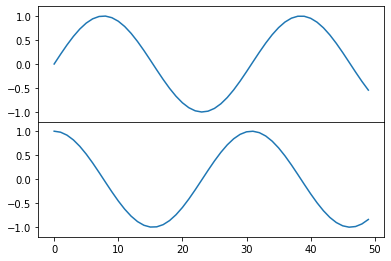

In [33]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1.2, 1.2))

x = np.linspace(0, 10)
ax1.plot(np.sin(x))
ax2.plot(np.cos(x));

<Figure size 288x576 with 0 Axes>

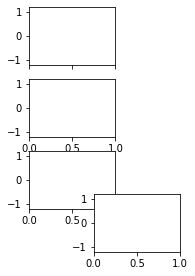

In [42]:
import matplotlib.gridspec as gridspec
from matplotlib import cm
f = plt.figure(figsize=(4, 8))
fig = plt.figure()
###  The dimensions [left, bottom, width, height] of the new axes.
## All quantities are in fractions of figure width and height.
ax1 = fig.add_axes([0.1, 0.75, 0.2, 0.2],xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.5, 0.2, 0.2],ylim=(-1.2, 1.2))

ax3 = fig.add_axes([0.1, 0.25, 0.2, 0.2],ylim=(-1.2, 1.2))

ax4 = fig.add_axes([0.25, 0.1, 0.2, 0.2],ylim=(-1.2, 1.2))